## Instacart Market Basket Analysis using PySpark

The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on 01/17/2018. This anonymized dataset contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders

Reference: 
https://databricks.com/blog/2018/09/18/simplify-market-basket-analysis-using-fp-growth-on-databricks.html

https://s3.us-east-2.amazonaws.com/databricks-dennylee/notebooks/Market+Basket+Analysis+using+Instacart+Online+Grocery+Dataset.html


### Frequent Pattern Mining
Spark MLlib implements two algorithms related to frequency pattern mining (FPM): FP-growth and PrefixSpan. The distinction is that FP-growth does not use order information in the itemsets, if any, while PrefixSpan is designed for sequential pattern mining where the itemsets are ordered. We will use FP-growth as the order information is not important for this use case.

### Load Data

- Upload the instacart data into RCC
- Load the Instacart data into HDFS

In [ ]:
#!mkdir /home/$USER/data/instacart
#!hdfs dfs -mkdir /user/$USER/data/instacart
#!hadoop dfs -put /home/$USER/data/instacart /user/$USER/data/instacart

### Data Model

`orders` (3.4m rows, 206k users):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`departments` (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)
* `"test"`: test data reserved for machine learning competitions (~75k orders)

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MarketBasketAnalysis').getOrCreate()

%matplotlib inline

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a906b7f4-930b-4f1f-9173-df8911ab0563;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.4.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.16.0 in central
	found com.google.guava#guava;31.1-jre in centra

### Import Data

In [10]:
# Import Data
dataDir = "gs://msca-bdp-student-gcs/instacart/"
aisles = spark.read.csv(dataDir + "aisles.csv", header=True, inferSchema=True)
departments = spark.read.csv(dataDir + "departments.csv", header=True, inferSchema=True)
order_products_prior = spark.read.csv(dataDir + "order_products__prior.csv", header=True, inferSchema=True)
order_products_train = spark.read.csv(dataDir + "order_products__train.csv", header=True, inferSchema=True)
orders = spark.read.csv(dataDir + "orders.csv", header=True, inferSchema=True)
products = spark.read.csv(dataDir + "products.csv", header=True, inferSchema=True)

# Create Temporary Tables
aisles.createOrReplaceTempView("aisles")
departments.createOrReplaceTempView("departments")
order_products_prior.createOrReplaceTempView("order_products_prior")
order_products_train.createOrReplaceTempView("order_products_train")
orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")

In [11]:
orders.count()

3421083

In [12]:
orders.show()

+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  null|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
|  473747|      1|   prior|           3|        3|               12|                  21.0|
| 2254736|      1|   prior|           4|        4|                7|                  29.0|
|  431534|      1|   prior|           5|        4|               15|                  28.0|
| 3367565|      1|   prior|           6|        2|                7|                  19.0|
|  550135|      1|   prior|           7|        1|                9|                  20.0|
| 3108588|      1|   prior|           8|        1|               14|            

## Exploratory Data Analysis

Now that you have created DataFrames, you can perform exploratory data analysis using Spark SQL.  The following queries showcase some of the quick insight you can gain from the Instacart dataset.


### Orders by Day of Week

Sunday is the most popular day for the total number of orders while Thursday has the least number of orders.

<AxesSubplot:xlabel='day_of_week'>

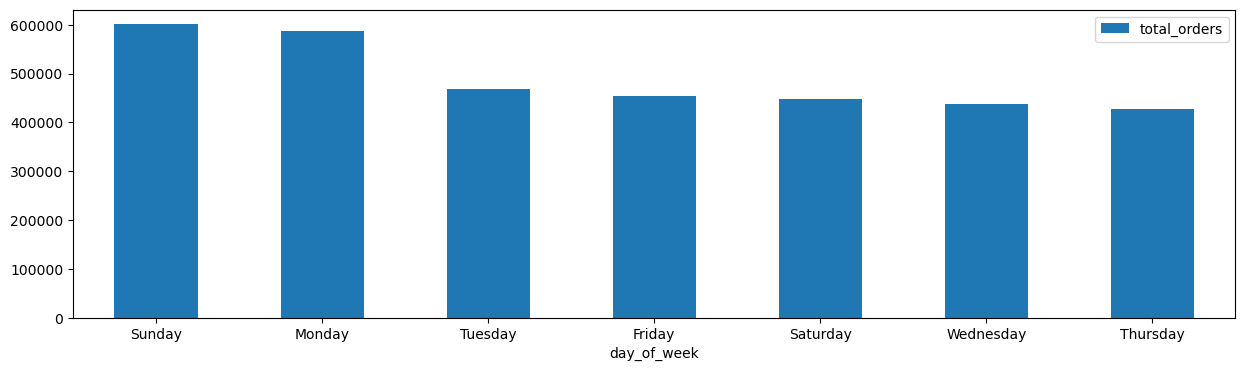

In [13]:
obw = spark.sql('''select 
  count(order_id) as total_orders, 
  (case 
     when order_dow = '0' then 'Sunday'
     when order_dow = '1' then 'Monday'
     when order_dow = '2' then 'Tuesday'
     when order_dow = '3' then 'Wednesday'
     when order_dow = '4' then 'Thursday'
     when order_dow = '5' then 'Friday'
     when order_dow = '6' then 'Saturday'              
   end) as day_of_week 
  from orders  
 group by order_dow 
 order by total_orders desc''')

obw.toPandas().plot(y='total_orders' , x ='day_of_week', kind='bar', figsize=(15,4), rot=0)

### Orders by Hour

When breaking down the hours typically people are ordering their groceries from Instacart during business working hours with highest number orders at 10:00am.

<AxesSubplot:>

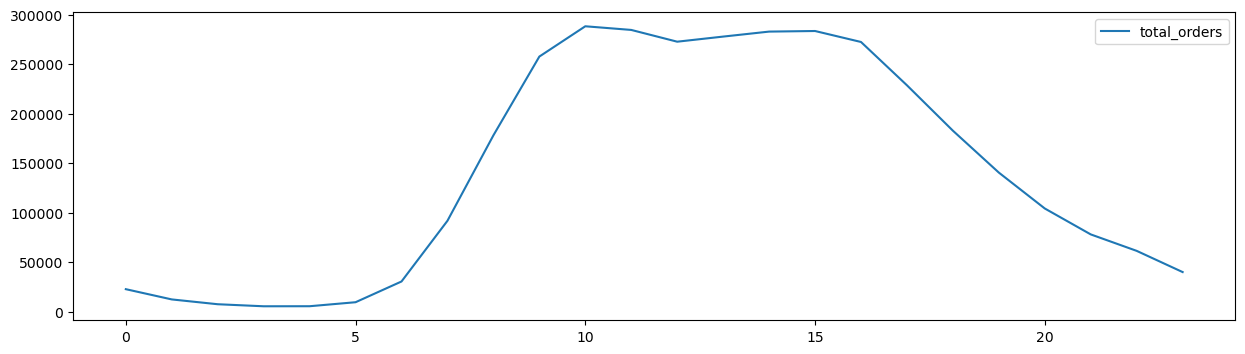

In [14]:
obh = spark.sql('''select 
  count(order_id) as total_orders, 
  order_hour_of_day as hour 
  from orders 
 group by order_hour_of_day 
 order by order_hour_of_day''')

obh.toPandas().plot(y='total_orders', figsize=(15,4))

### Top 10 Popular Items

In [15]:
spark.sql('''select count(opp.order_id) as orders, p.product_name as popular_product
  from order_products_prior opp, products p
 where p.product_id = opp.product_id 
 group by popular_product 
 order by orders desc 
 limit 10''').show(truncate = False)

+------+----------------------+
|orders|popular_product       |
+------+----------------------+
|472565|Banana                |
|379450|Bag of Organic Bananas|
|264683|Organic Strawberries  |
|241921|Organic Baby Spinach  |
|213584|Organic Hass Avocado  |
|176815|Organic Avocado       |
|152657|Large Lemon           |
|142951|Strawberries          |
|140627|Limes                 |
|137905|Organic Whole Milk    |
+------+----------------------+



### Understand shelf space by department

As we dive deeper into our market basket analysis, we can gain insight on the number of products by department to understand how much shelf space is being used.

In [16]:
spark.sql('''select d.department, count(distinct p.product_id) as products
  from products p
    inner join departments d
      on d.department_id = p.department_id
 group by d.department
 order by products desc
 limit 10''').show()

+---------------+--------+
|     department|products|
+---------------+--------+
|  personal care|    6563|
|         snacks|    6264|
|         pantry|    5371|
|      beverages|    4365|
|         frozen|    4007|
|     dairy eggs|    3449|
|      household|    3084|
|   canned goods|    2092|
|dry goods pasta|    1858|
|        produce|    1684|
+---------------+--------+



### Max Products By Department

In [17]:
spark.sql('''select countbydept.*
  from (
  -- from product table, let's count number of records per dept
  -- and then sort it by count (highest to lowest) 
  select department_id, count(1) as counter
    from products
   group by department_id
   order by counter asc 
  ) as maxcount
inner join (
  -- let's repeat the exercise, but this time let's join
  -- products and departments tables to get a full list of dept and 
  -- prod count
  select
    d.department_id,
    d.department,
    count(1) as products
    from departments d
      inner join products p
         on p.department_id = d.department_id
   group by d.department_id, d.department 
   order by products desc
  ) countbydept 
  -- combine the two queries's results by matching the product count
  on countbydept.products = maxcount.counter''').show()

+-------------+---------------+--------+
|department_id|     department|products|
+-------------+---------------+--------+
|           16|     dairy eggs|    3449|
|           14|      breakfast|    1115|
|            3|         bakery|    1516|
|           21|        missing|    1258|
|            6|  international|    1139|
|            1|         frozen|    4007|
|           11|  personal care|    6563|
|            9|dry goods pasta|    1858|
|           13|         pantry|    5371|
|           19|         snacks|    6264|
|           20|           deli|    1322|
|            7|      beverages|    4365|
|            4|        produce|    1684|
|           15|   canned goods|    2092|
|           12|   meat seafood|     907|
|           18|         babies|    1081|
|            2|          other|     548|
|            8|           pets|     972|
|            5|        alcohol|    1054|
|           10|           bulk|      38|
+-------------+---------------+--------+
only showing top

## Association Mining

### Organize Shopping Basket

To prepare our data for downstream processing, we will organize our data by shopping basket. That is, each row of our DataFrame represents an order_id with each items column containing an array of items.

In [18]:
# Organize the by shopping basket
from pyspark.sql.functions import collect_set, col, count
rawData = spark.sql("select p.product_name, o.order_id from products p inner join order_products_train o where o.product_id = p.product_id")
baskets = rawData.groupBy('order_id').agg(collect_set('product_name').alias('items'))
baskets.createOrReplaceTempView('baskets')
baskets.show(truncate=100)

+--------+----------------------------------------------------------------------------------------------------+
|order_id|                                                                                               items|
+--------+----------------------------------------------------------------------------------------------------+
|       1|[Bag of Organic Bananas, Cucumber Kirby, Lightly Smoked Sardines in Olive Oil, Organic 4% Milk Fa...|
|      96|[Roasted Turkey, Organic Cucumber, Organic Raspberries, Organic Whole Strawberries, Organic Grape...|
|     112|[Umcka Elderberry Intensive Cold + Flu Berry Flavor, Fresh Cauliflower, I Heart Baby Kale, Hickor...|
|     218|         [Okra, Black Plum, Citrus Mandarins Organic, Organic Yellow Peaches, Natural Artisan Water]|
|     456|[Petite Peas, Large Lemon, Pure Ground, Max Gel Clog Remover, Green Beans, Extra Virgin Olive Oil...|
|     473|[Organic Whole Milk with DHA Omega-3, Basil Pesto, Multi Grain Waffles, Baby Wipes, Mushroom R

### Frequent Itemsets

The FP-Growth (Frequent Pattern growth) algorithm is currently one of the fastest approaches to frequent item set mining. FP-Growth is an improvement of apriori designed to eliminate some of the heavy bottlenecks in apriori. It works well with any distributed system focused on MapReduce. FP-Growth simplifies all the problems present in apriori by using a structure called an FP-Tree.

Given a dataset of transactions, the first step of FP-growth is to calculate item frequencies and identify frequent items. Different from Apriori-like algorithms designed for the same purpose, the second step of FP-growth uses a suffix tree (FP-tree) structure to encode transactions without generating candidate sets explicitly, which are usually expensive to generate.

In [19]:
from pyspark.ml.fpm import FPGrowth

#set the minimum thresholds for support and confidence
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.001, minConfidence=0)

model = fpGrowth.fit(baskets)

#Calculate frequent itemsets
mostPopularItemInABasket = model.freqItemsets
mostPopularItemInABasket.createOrReplaceTempView("mostPopularItemInABasket")

# Display frequent itemsets.
model.freqItemsets.show(truncate =False)

+--------------------------------------------------+----+
|items                                             |freq|
+--------------------------------------------------+----+
|[Crispy Wheat, Crackers]                          |254 |
|[Bok Choy]                                        |259 |
|[Organic Lime]                                    |140 |
|[Canned Aranciata Orange]                         |285 |
|[Cheddar Cheese Nut Thins Cracker Snacks]         |135 |
|[Hazelnut Spread With Skim Milk & Cocoa]          |283 |
|[Organic Greek Lowfat Yogurt With Strawberries]   |263 |
|[Wild Berry Smoothie]                             |262 |
|[Coconut Sparkling Water]                         |143 |
|[Creamy Swiss Original Wedges Cheese]             |141 |
|[Whole Grain Oat Cereal]                          |301 |
|[Orange Juice 100% Juice]                         |136 |
|[Jalapeno Hummus]                                 |298 |
|[Squeeze Real Mayonnaise]                         |135 |
|[California S

In [20]:
#only show item groups larger than 2
spark.sql('''select items, freq from mostPopularItemInABasket 
          where size(items) > 2 order by freq desc limit 20''').show(truncate =False)

+--------------------------------------------------------------------+----+
|items                                                               |freq|
+--------------------------------------------------------------------+----+
|[Organic Hass Avocado, Organic Strawberries, Bag of Organic Bananas]|710 |
|[Organic Raspberries, Organic Strawberries, Bag of Organic Bananas] |649 |
|[Organic Baby Spinach, Organic Strawberries, Bag of Organic Bananas]|587 |
|[Organic Raspberries, Organic Hass Avocado, Bag of Organic Bananas] |531 |
|[Organic Hass Avocado, Organic Baby Spinach, Bag of Organic Bananas]|497 |
|[Organic Avocado, Organic Baby Spinach, Banana]                     |484 |
|[Organic Avocado, Large Lemon, Banana]                              |477 |
|[Limes, Large Lemon, Banana]                                        |452 |
|[Organic Cucumber, Organic Strawberries, Bag of Organic Bananas]    |424 |
|[Limes, Organic Avocado, Large Lemon]                               |389 |
|[Organic Ra

### Association Rules

In [21]:
model.associationRules.show(25, truncate=False)

+----------------------------+-------------------------+-------------------+------------------+---------------------+
|antecedent                  |consequent               |confidence         |lift              |support              |
+----------------------------+-------------------------+-------------------+------------------+---------------------+
|[Yellow Onions, Large Lemon]|[Limes]                  |0.23962516733601072|5.2114998476695895|0.0013642356850520924|
|[Yellow Onions, Large Lemon]|[Organic Avocado]        |0.2101740294511379 |3.7220575287156636|0.001196564260073623 |
|[Yellow Onions, Large Lemon]|[Organic Baby Spinach]   |0.19812583668005354|2.656980059786707 |0.0011279714044006128|
|[Yellow Onions, Large Lemon]|[Banana]                 |0.34404283801874164|2.410633169582456 |0.001958707100884848 |
|[Yellow Onions, Banana]     |[Limes]                  |0.14285714285714285|3.106935663375246 |0.001166078546441174 |
|[Yellow Onions, Banana]     |[Organic Avocado]        |

In [22]:
#sort by confidence
model.associationRules.orderBy("confidence", ascending=False).show(25, truncate=False)

+------------------------------------------------------------------+------------------------+-------------------+------------------+---------------------+
|antecedent                                                        |consequent              |confidence         |lift              |support              |
+------------------------------------------------------------------+------------------------+-------------------+------------------+---------------------+
|[Organic Raspberries, Organic Hass Avocado, Organic Strawberries] |[Bag of Organic Bananas]|0.5984251968503937 |5.072272070642333 |0.0017376856770495927|
|[Organic Cucumber, Organic Hass Avocado, Organic Strawberries]    |[Bag of Organic Bananas]|0.546875           |4.635330870478036 |0.0010669999771357147|
|[Organic Kiwi, Organic Hass Avocado]                              |[Bag of Organic Bananas]|0.5459770114942529 |4.627719489738336 |0.001448071397541327 |
|[Organic Navel Orange, Organic Raspberries]                       |[B

### Predictions

In [23]:
# transform examines the input items against all the association rules and summarize the
# consequents as prediction
model.transform(baskets).show(truncate=70)

+--------+----------------------------------------------------------------------+----------------------------------------------------------------------+
|order_id|                                                                 items|                                                            prediction|
+--------+----------------------------------------------------------------------+----------------------------------------------------------------------+
|     762|[Organic Cucumber, Organic Romaine Lettuce, Celery Hearts, Organic ...|[Bag of Organic Bananas, Crackers Cheddar Bunnies Snack Packs, Bake...|
|     844|[Organic Red Radish, Bunch, Baby Spinach, Organic Shredded Carrots,...|[Large Lemon, Strawberries, Banana, Limes, Organic Strawberries, Ba...|
|     988|[Whipped Light Cream, Original, Complete ActionPacs Lemon Burst Dis...|                                                                    []|
|    1077|[Sparkling Water, Organic Strawberries, Celery Sticks, Bag of Organ...|[